In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

(32, 256, 256, 3)
[0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1]


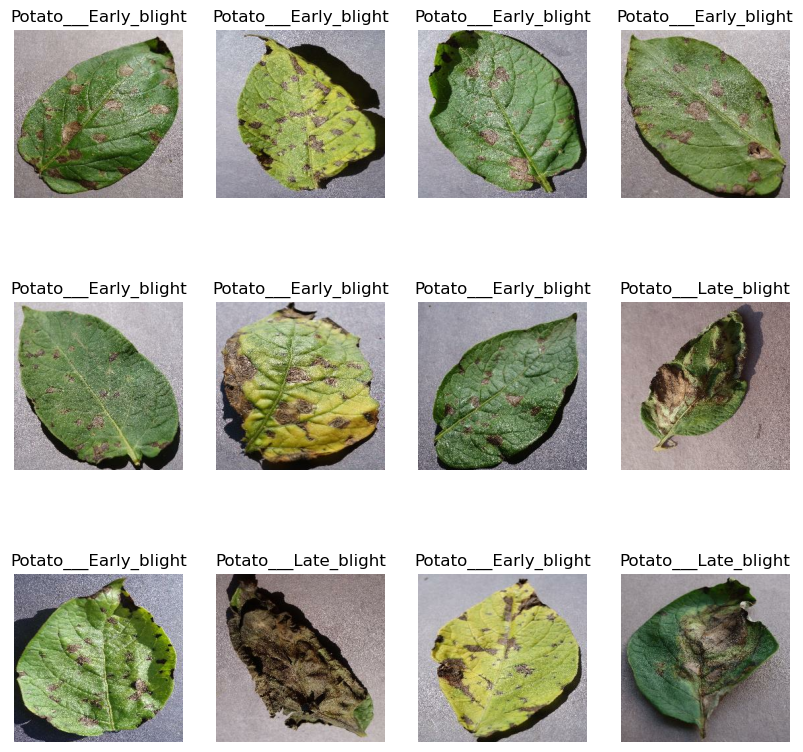

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.9, val_split=0.05, test_split=0.05, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

61 3 4


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
61/61 [==============================] - 82s 1s/step - loss: 0.8722 - accuracy: 0.5482 - val_loss: 0.6886 - val_accuracy: 0.7500
Epoch 2/20
61/61 [==============================] - 82s 1s/step - loss: 0.5822 - accuracy: 0.7469 - val_loss: 0.3369 - val_accuracy: 0.8854
Epoch 3/20
61/61 [==============================] - 82s 1s/step - loss: 0.3934 - accuracy: 0.8309 - val_loss: 0.2630 - val_accuracy: 0.9062
Epoch 4/20
61/61 [==============================] - 82s 1s/step - loss: 0.3109 - accuracy: 0.8729 - val_loss: 0.2605 - val_accuracy: 0.9271
Epoch 5/20
61/61 [==============================] - 81s 1s/step - loss: 0.2686 - accuracy: 0.8895 - val_loss: 0.2510 - val_accuracy: 0.8750
Epoch 6/20
61/61 [==============================] - 81s 1s/step - loss: 0.2364 - accuracy: 0.9015 - val_loss: 0.1927 - val_accuracy: 0.9271
Epoch 7/20
61/61 [==============================] - 81s 1s/step - loss: 0.2057 - accuracy: 0.9191 - val_loss: 0.2263 - val_accuracy: 0.9167
Epoch 8/20
61/61 [==

In [13]:
scores=model.evaluate(test_ds)
scores

4/4 [==============================] - 2s 221ms/step - loss: 0.1881 - accuracy: 0.8984


[0.18812009692192078, 0.8984375]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[0.872188925743103,
 0.5822120308876038,
 0.39342784881591797,
 0.3108532130718231,
 0.2686315178871155,
 0.2364422231912613,
 0.20568101108074188,
 0.2027064859867096,
 0.16009940207004547,
 0.18851573765277863,
 0.14876887202262878,
 0.16681161522865295,
 0.14811761677265167,
 0.15961074829101562,
 0.15993112325668335,
 0.1245555654168129,
 0.09041250497102737,
 0.09415525197982788,
 0.0716773197054863,
 0.1094750240445137]

In [16]:
history.history['accuracy']

[0.5482364892959595,
 0.7468879818916321,
 0.8309128880500793,
 0.8729252815246582,
 0.8895228505134583,
 0.9014523029327393,
 0.9190871119499207,
 0.9216805100440979,
 0.9341286420822144,
 0.9336099624633789,
 0.942427396774292,
 0.9320539236068726,
 0.9434647560119629,
 0.9367219805717468,
 0.9346473217010498,
 0.9491701126098633,
 0.9699169993400574,
 0.9683610200881958,
 0.9751037359237671,
 0.9631742835044861]

In [17]:
history.history['val_loss']

[0.6885762810707092,
 0.3368627727031708,
 0.2630273401737213,
 0.2605036497116089,
 0.2510054111480713,
 0.19272251427173615,
 0.22626793384552002,
 0.1480950117111206,
 0.13595405220985413,
 0.11526206135749817,
 0.11291513592004776,
 0.14254701137542725,
 0.20886461436748505,
 0.150094136595726,
 0.11045227199792862,
 0.14205487072467804,
 0.07936468720436096,
 0.048183050006628036,
 0.16741438210010529,
 0.09946676343679428]

In [18]:
history.history['val_accuracy']

[0.75,
 0.8854166865348816,
 0.90625,
 0.9270833134651184,
 0.875,
 0.9270833134651184,
 0.9166666865348816,
 0.96875,
 0.9375,
 0.96875,
 0.9583333134651184,
 0.9166666865348816,
 0.90625,
 0.9375,
 0.9895833134651184,
 0.9375,
 0.96875,
 0.96875,
 0.90625,
 0.9479166865348816]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

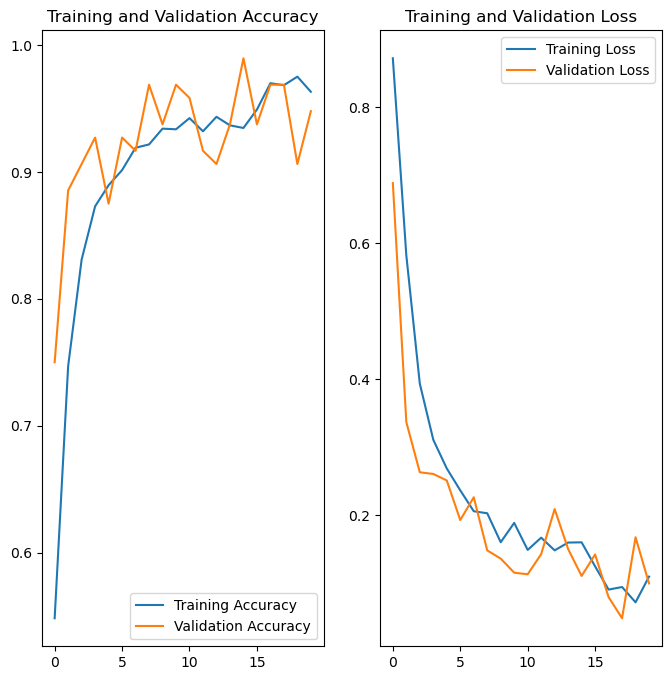

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [22]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(4):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 311ms/step


In [23]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 47ms/step


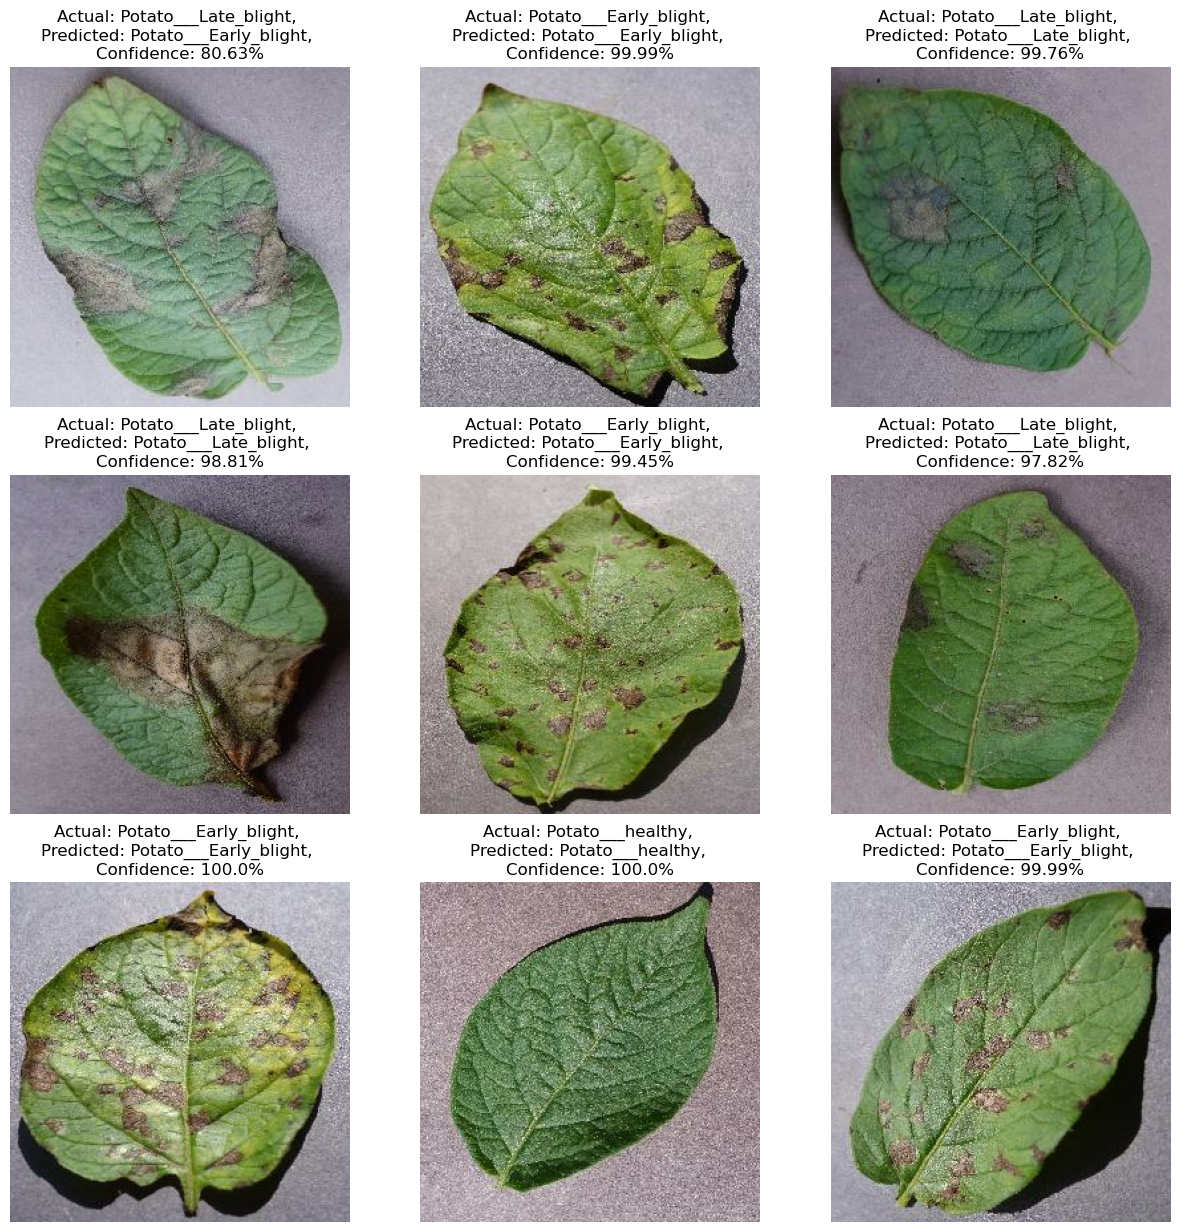

In [24]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [25]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.82      1.00      0.90        56
           1       1.00      0.80      0.89        65
           2       0.88      1.00      0.93         7

    accuracy                           0.90       128
   macro avg       0.90      0.93      0.91       128
weighted avg       0.92      0.90      0.90       128



In [26]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[56,  0,  0],
       [12, 52,  1],
       [ 0,  0,  7]])>

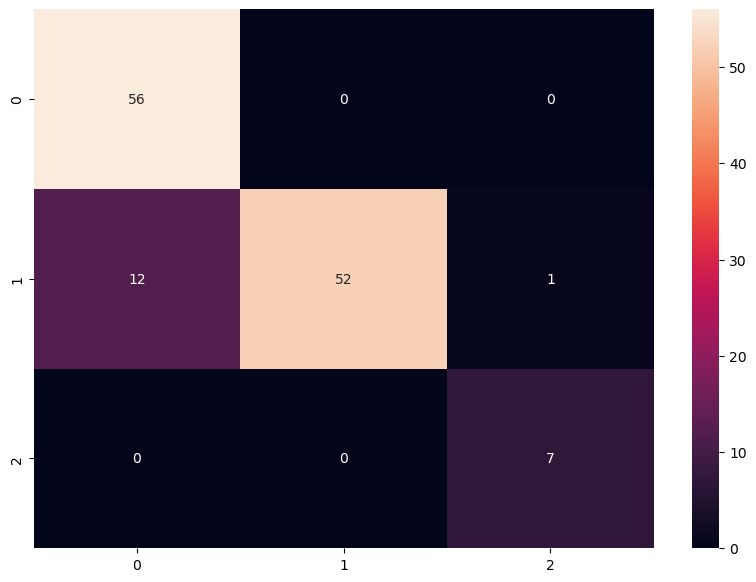

In [27]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [28]:
filename = "Model1-DatasetSplit90-5-5.joblib"
joblib.dump(model, filename)

['Model1-DatasetSplit90-5-5.joblib']